# Ungraded Lab: Feature Engineering with Accelerometer Data

This notebook demonstrates how to prepare time series data taken from an accelerometer. We will be using the [WISDM Human Activity Recognition Dataset](http://www.cis.fordham.edu/wisdm/dataset.php) for this example. This dataset can be used to predict the activity a user performs from a set of acceleration values recorded from the accelerometer of a smartphone.

The dataset consists of accelerometer data in the x, y, and z-axis recorded for 36 user different users. A total of 6 activities: 'Walking','Jogging', 'Upstairs', 'Downstairs', 'Sitting', and 'Standing' were recorded. The sensors have a sampling rate of 20Hz which means there are 20 observations recorded per second.

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from tfx_bsl.coders.example_coder import RecordBatchToExamplesEncoder
from tfx_bsl.public import tfxio

import apache_beam as beam
print('Apache Beam version: {}'.format(beam.__version__))

import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))

import tensorflow_transform as tft
from tensorflow_transform import beam as tft_beam
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import schema_utils
print('TensorFlow Transform version: {}'.format(tft.__version__))

tf.get_logger().setLevel('ERROR')
beam.logging.getLogger().setLevel('ERROR')

Apache Beam version: 2.46.0
Tensorflow version: 2.11.0
TensorFlow Transform version: 1.12.0


## Load and Inspect the Data

In [2]:
# Directory of the raw data files
DATA_DIR = './data/'

# Assign data path to a variable for easy reference
INPUT_FILE = os.path.join(DATA_DIR, 'WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

You should now inspect the dataset and you can start by previewing it as a dataframe.

In [3]:
# Put dataset in a dataframe
df = pd.read_csv(INPUT_FILE, header=None, names=['user_id', 'activity', 'timestamp', 'x-acc','y-acc', 'z-acc'], on_bad_lines='skip')

# Preview the first few rows
df.head()

,user_id,activity,timestamp,x-acc,y-acc,z-acc
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


You might notice the semicolon at the end of the `z-acc` elements. This might cause the elements to be treated as a string so you may want to remove it when analyzing your data. You will do this later in the pipeline with [Beam.map()](https://beam.apache.org/documentation/transforms/python/elementwise/map/). This is also taken care of by the `visualize_plots()` function below which you will use in the next section.

In [4]:
# Visulaization Utilities
def visualize_value_plots_for_categorical_feature(feature, colors=['b']):
    '''Plots a bar graph for categorical features'''
    counts = feature.value_counts()
    plt.bar(counts.index, counts.values, color=colors)
    plt.show()


def visualize_plots(dataset, activity, columns):
    '''Visualizes the accelerometer data against time'''
    features = dataset[dataset['activity'] == activity][columns][:200]
    if 'z-acc' in columns:
        # remove semicolons in the z-acc column
        features['z-acc'] = features['z-acc'].replace(regex=True, to_replace=r';', value=r'')
        features['z-acc'] = features['z-acc'].astype(np.float64)
    axis = features.plot(subplots=True, figsize=(16, 12), 
                     title=activity)

    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

### Histogram of Activities

You can now proceed with the visualizations. You can plot the histogram of activities and make your observations. For instance, you'll notice that there is more data for walking and jogging than other activities. This might have an effect on how your model learns each activity so you should take note of it. For example, you may want to collect more data for the other activities.

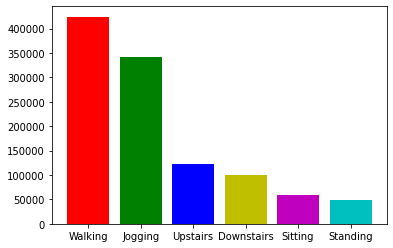

In [5]:
# Plot the histogram of activities
visualize_value_plots_for_categorical_feature(df['activity'], colors=['r', 'g', 'b', 'y', 'm', 'c'])

### Histogram of Measurements per User
You can also observe the number of measurements taken per user.

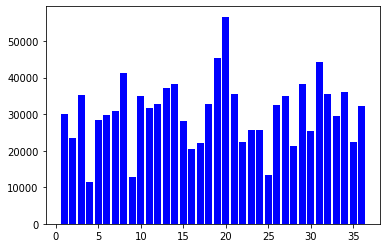

In [6]:
# Plot the histogram for users
visualize_value_plots_for_categorical_feature(df['user_id'])

You can consult with field experts on which of the users you should be part of the training or test set. For this lab, you will just do a simple partition. You will put user ids 1 to 30 in the train set, and the rest in the test set. Here is the `partition_fn` you will use for `Beam.Partition()` later.

In [7]:
def partition_fn(line, num_partitions):
    '''
    Partition function to work with Beam.partition

    Args:
    line (string) - One record in the CSV file.
    num_partition (integer) - Number of partitions. Required argument by Beam. Unused in this function.

    Returns:
    0 or 1 (integer) - 0 if user id is less than 30, 1 otherwise. 
    '''

    # Get the 1st substring delimited by a comma. Cast to an int.
    user_id = int(line[:line.index(b',')])

    # Check if it is above or below 30
    partition_num = int(user_id <= 30)

    return partition_num

### Acceleration per Activity

Finally, you can plot the sensor measurements against the timestamps. You can observe that acceleration is more for activities like jogging when compared to sitting which should be the expected behaviour. If this is not the case, then there might be problems with the sensor and can make the data invalid.

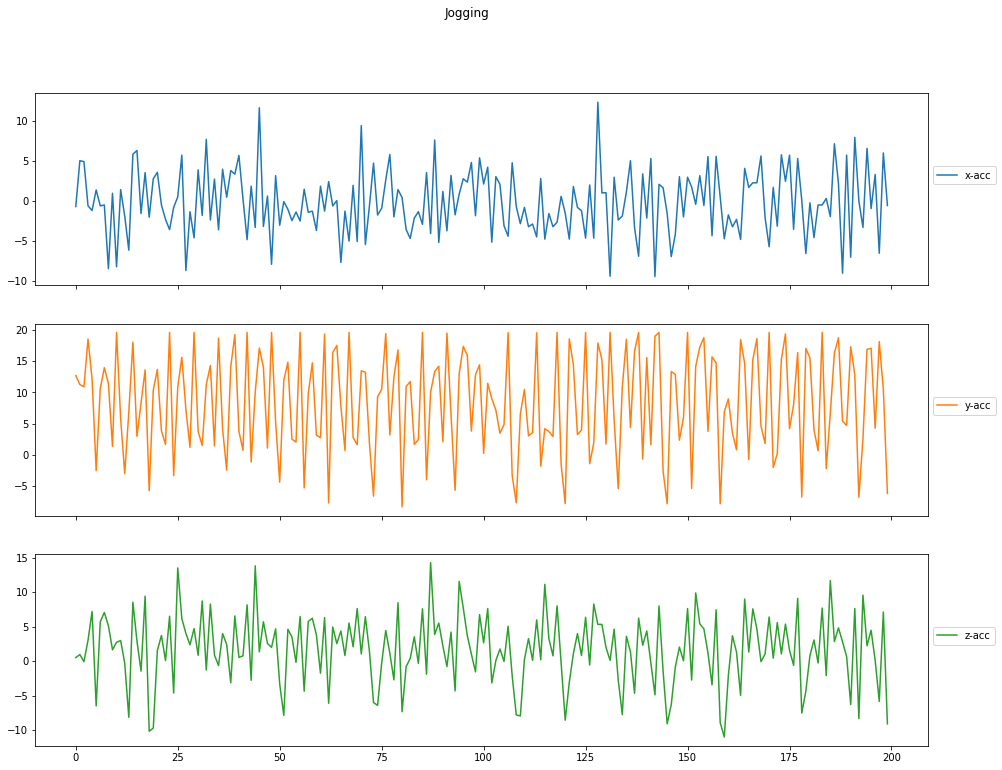

In [8]:
# Plot the measurements for `Jogging`
visualize_plots(df, 'Jogging', columns=['x-acc', 'y-acc', 'z-acc'])

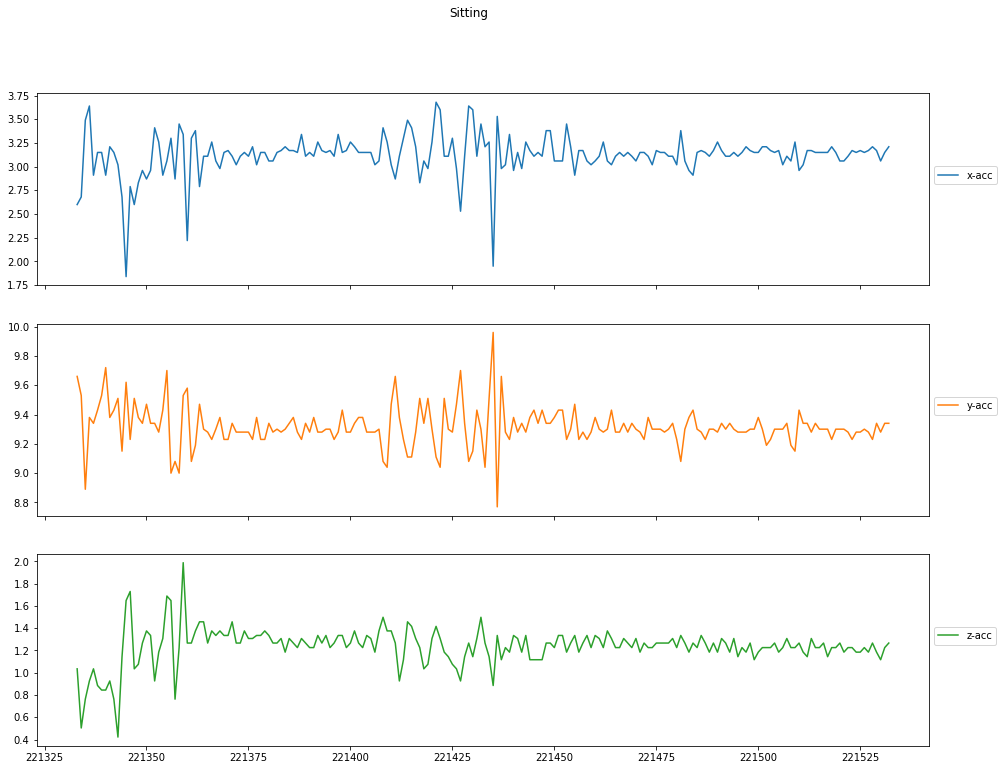

In [9]:
visualize_plots(df, 'Sitting', columns=['x-acc', 'y-acc', 'z-acc'])

## Declare Schema for Cleaned Data

As usual, you will want to declare a schema to make sure that your data input is parsed correctly.

In [10]:
STRING_FEATURES = ['activity']
INT_FEATURES = ['user_id', 'timestamp']
FLOAT_FEATURES = ['x-acc', 'y-acc', 'z-acc']

# Declare feature spec
RAW_DATA_FEATURE_SPEC = dict(
    [(name, tf.io.FixedLenFeature([], tf.string))
     for name in STRING_FEATURES] +
    [(name, tf.io.FixedLenFeature([], tf.int64))
     for name in INT_FEATURES] +
    [(name, tf.io.FixedLenFeature([], tf.float32))
     for name in FLOAT_FEATURES]
)

# Create schema from feature spec
RAW_DATA_SCHEMA = tft.tf_metadata.schema_utils.schema_from_feature_spec(RAW_DATA_FEATURE_SPEC)

## Create a `tf.Transform` preprocessing_fn

You can then define your preprocessing function. For this exercise, you will scale the float features by their min-max values and create a vocabulary lookup for the string label. You will also discard features that you will not need in the model such as the user id and timestamp.

In [11]:
LABEL_KEY = 'activity'

def preprocessing_fn(inputs):
    """Preprocess input columns into transformed columns."""

    # Copy inputs
    outputs = inputs.copy()

    # Delete features not to be included as inputs to the model
    del outputs["user_id"]
    del outputs["timestamp"]

    # Create a vocabulary for the string labels
    outputs[LABEL_KEY] = tft.compute_and_apply_vocabulary(inputs[LABEL_KEY],vocab_filename=LABEL_KEY)

    # Scale features by their min-max
    for key in FLOAT_FEATURES:
        outputs[key] = tft.scale_by_min_max(outputs[key])

    return outputs

## Transform the data

Now you're ready to start transforming the data in an Apache Beam pipeline using Tensorflow Transform. It will follow these major steps:

1. Read in the data using `beam.io.ReadFromText`
1. Clean it using `beam.Map` and `beam.Filter`
1. Transform it using a preprocessing pipeline that scales numeric data and converts categorical data from strings to int64 values indices. 
1. Write out the result as a `TFRecord` of `Example` protos, which can be used for training a model later.

In [12]:
# Directory names for the TF Transform outputs
WORKING_DIR = 'transform_dir_signals'
TRANSFORM_TRAIN_FILENAME = 'transform_train'
TRANSFORM_TEST_FILENAME = 'transform_test'
TRANSFORM_TEMP_DIR = 'tft_temp'

ordered_columns = ['user_id', 'activity', 'timestamp', 'x-acc','y-acc', 'z-acc']

def transform_data(working_dir):
    '''
    Reads a CSV File and preprocesses the data using TF Transform

    Args:
      working_dir (string) - directory to place TF Transform outputs
    
    Returns:
      transform_fn - transformation graph
      transformed_train_data - transformed training examples
      transformed_test_data - transformed test examples
      transformed_metadata - transform output metadata
    '''

    # Delete TF Transform if it already exists
    if os.path.exists(working_dir):
        shutil.rmtree(working_dir)

    with beam.Pipeline() as pipeline:
        with tft_beam.Context(temp_dir=os.path.join(working_dir, TRANSFORM_TEMP_DIR)):
  
          # Read the input CSV, clean and filter the data (replace semicolon and incomplete rows)
          raw_data = (
              pipeline
              | 'ReadTrainData' >> beam.io.ReadFromText(INPUT_FILE, coder=beam.coders.BytesCoder())
              | 'CleanLines' >> beam.Map(lambda line: line.replace(b',;', b'').replace(b';', b''))
              | 'FilterLines' >> beam.Filter(lambda line: line.count(b',') == len(ordered_columns) - 1 and line[-1:] != b','))

          # Partition the data into training and test data using beam.Partition
          raw_train_data, raw_test_data = (raw_data
                                  | 'TrainTestSplit' >> beam.Partition(partition_fn, 2))
                    
          # Create a TFXIO to read the data with the schema. 
          csv_tfxio = tfxio.BeamRecordCsvTFXIO(
              physical_format='text',
              column_names=ordered_columns,
              schema=RAW_DATA_SCHEMA)

          # Parse the raw train data into inputs for TF Transform
          raw_train_data = (raw_train_data 
                            | 'DecodeTrainData' >> csv_tfxio.BeamSource())

          # Get the raw data metadata
          RAW_DATA_METADATA = csv_tfxio.TensorAdapterConfig()
          
          # Pair the test data with the metadata into a tuple
          raw_train_dataset = (raw_train_data, RAW_DATA_METADATA)

          # Training data transformation. The TFXIO (RecordBatch) output format
          # is chosen for improved performance.
          (transformed_train_data,transformed_metadata) , transform_fn = (
              raw_train_dataset 
                | 'AnalyzeAndTransformTrainData' >> tft_beam.AnalyzeAndTransformDataset(preprocessing_fn, output_record_batches=True))
          
          # Parse the raw test data into inputs for TF Transform
          raw_test_data = (raw_test_data 
                            |'DecodeTestData' >> csv_tfxio.BeamSource())

          # Pair the test data with the metadata into a tuple
          raw_test_dataset = (raw_test_data, RAW_DATA_METADATA)

          # Now apply the same transform function to the test data.
          # You don't need the transformed data schema. It's the same as before.
          transformed_test_data, _ = ((raw_test_dataset, transform_fn) 
                                        | 'AnalyzeAndTransformTestData' >> tft_beam.TransformDataset(output_record_batches=True))
          
          # Declare an encoder to convert output record batches to TF Examples 
          transformed_data_coder = RecordBatchToExamplesEncoder(transformed_metadata.schema)

          
          # Encode transformed train data and write to disk
          _ = (
              transformed_train_data
              | 'EncodeTrainData' >> beam.FlatMapTuple(lambda batch, _: transformed_data_coder.encode(batch))
              | 'WriteTrainData' >> beam.io.WriteToTFRecord(
                  os.path.join(working_dir, TRANSFORM_TRAIN_FILENAME)))

          # Encode transformed test data and write to disk
          _ = (
              transformed_test_data
              | 'EncodeTestData' >> beam.FlatMapTuple(lambda batch, _: transformed_data_coder.encode(batch))
              | 'WriteTestData' >> beam.io.WriteToTFRecord(
                  os.path.join(working_dir, TRANSFORM_TEST_FILENAME)))
          
          # Write transform function to disk
          _ = (
            transform_fn
            | 'WriteTransformFn' >>
            tft_beam.WriteTransformFn(os.path.join(working_dir)))

    return transform_fn, transformed_train_data, transformed_test_data, transformed_metadata

In [13]:
def main():
    return transform_data(WORKING_DIR)

if __name__ == '__main__':
    transform_fn, transformed_train_data,transformed_test_data, transformed_metadata = main()


## Prepare Training and Test Datasets from TFTransformOutput

Now that you have the transformed examples, you now need to prepare the dataset windows for this time series data. As discussed in class, you want to group a series of measurements and that will be the feature for a particular label. In this particular case, it makes sense to group consecutive measurements and use that as the indicator for an activity. For example, if you take 80 measurements and it oscillates greatly (just like in the visualizations in the earlier parts of this notebook), then the model should be able to tell that it is a 'Running' activity. Let's implement that in the following cells using the [tf.data.Dataset.window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method. Notice that there is an `add_mode()` function. If you remember how the original CSV looks like, you'll notice that each row has an activity label. Thus if we want to associate a single activity to a group of 80 measurements, then we just get the activity that is mentioned most in all those rows (e.g. if 75 elements of the window point to `Walking` activity and only 5 point to 'Sitting`, then the entire window is associated to `Walking`).

In [14]:
# Get the output of the Transform component
tf_transform_output = tft.TFTransformOutput(os.path.join(WORKING_DIR))

# Parameters
HISTORY_SIZE = 80
BATCH_SIZE = 100
STEP_SIZE = 40

def parse_function(example_proto):
    '''Parse the values from tf examples'''
    feature_spec = tf_transform_output.transformed_feature_spec()
    features = tf.io.parse_single_example(example_proto, feature_spec)
    values = list(features.values())
    values = [float(value) for value in values]
    features = tf.stack(values, axis=0)
    return features

def add_mode(features):
    '''Calculate mode of activity for the current history size of elements'''
    unique, _, count = tf.unique_with_counts(features[:,0])
    max_occurrences = tf.reduce_max(count)
    max_cond = tf.equal(count, max_occurrences)
    max_numbers = tf.squeeze(tf.gather(unique, tf.where(max_cond)))

    #Features (X) are all features except activity (x-acc, y-acc, z-acc)
    #Target(Y) is the mode of activity values of all rows in this window
    return (features[:,1:], max_numbers)

def get_windowed_dataset(path):
    '''Get the dataset and group them into windows'''
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(parse_function)
    dataset = dataset.window(HISTORY_SIZE, shift=STEP_SIZE, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(HISTORY_SIZE))
    dataset = dataset.map(add_mode)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.repeat()

    return dataset

In [15]:
# Get list of train and test data tfrecord filenames from the transform outputs
train_tfrecord_files = tf.io.gfile.glob(os.path.join(WORKING_DIR, TRANSFORM_TRAIN_FILENAME + '*'))
test_tfrecord_files = tf.io.gfile.glob(os.path.join(WORKING_DIR, TRANSFORM_TEST_FILENAME + '*'))

# Generate dataset windows
windowed_train_dataset = get_windowed_dataset(train_tfrecord_files[0])
windowed_test_dataset = get_windowed_dataset(test_tfrecord_files[0])

In [16]:
# Preview an example in the train dataset
for x, y in windowed_train_dataset.take(1):
    print("\nFeatures (x-acc, y-acc, z-acc):\n")
    print(x)
    print("\nTarget (activity):\n")
    print(y)


Features (x-acc, y-acc, z-acc):

tf.Tensor(
[[[0.47814363 0.82018137 0.5200351 ]
  [0.6224036  0.7842018  0.53206956]
  [0.61964923 0.77451503 0.5043538 ]
  ...
  [0.64202845 0.57974094 0.5371751 ]
  [0.44543552 0.8143001  0.4336057 ]
  [0.53150946 0.92431456 0.73337346]]

 [[0.63892984 0.5942712  0.52076447]
  [0.5015558  0.5174686  0.526964  ]
  [0.37382194 0.9952359  0.72498584]
  ...
  [0.41444892 0.57316774 0.526964  ]
  [0.42890933 0.9952359  0.7209743 ]
  [0.5101631  0.46003968 0.49633083]]

 [[0.5063759  0.28809875 0.30961415]
  [0.4054972  0.7762448  0.48502573]
  [0.37760922 0.79596436 0.516753  ]
  ...
  [0.63617545 0.8717291  0.7056577 ]
  [0.5084416  0.30055326 0.26767585]
  [0.37657633 0.67314947 0.2111503 ]]

 ...

 [[0.45025566 0.82398695 0.63782704]
  [0.41341603 0.8589287  0.55796194]
  [0.33319503 0.66450053 0.5444687 ]
  ...
  [0.44818988 0.62852097 0.5988062 ]
  [0.44061536 0.55552393 0.60208833]
  [0.41823614 0.66934395 0.76692414]]

 [[0.41444892 0.73542184 0.52

You should see a sample of a dataset window above. There are 80 consecutive measurements of `x-acc`, `y-acc`, and `z-acc` that correspond to a single labeled activity. Moreover, you also set it up to be in batches of 100 windows. This can now be fed to train an LSTM so it can learn how to detect activities based on 80-measurement windows. You can also preview a sample in the test set:

In [17]:
# Preview an example in the train dataset
for x, y in windowed_test_dataset.take(1):
    print("\nFeatures (x-acc, y-acc, z-acc):\n")
    print(x)
    print("\nTarget (activity):\n")
    print(y)


Features (x-acc, y-acc, z-acc):

tf.Tensor(
[[[0.5101631  0.7471844  0.49231938]
  [0.4957027  0.75687116 0.49122533]
  [0.4898497  0.74822223 0.48794317]
  ...
  [0.59830296 0.6800686  0.5003423 ]
  [0.49949    0.5925414  0.5331636 ]
  [0.6168949  0.89421636 0.6400151 ]]

 [[0.53254235 0.71501034 0.5659849 ]
  [0.5346081  0.6984044  0.568173  ]
  [0.55664307 0.7160482  0.5856777 ]
  ...
  [0.5752351  0.7492601  0.4901313 ]
  [0.50913024 0.55932945 0.4759087 ]
  [0.58005524 0.7675959  0.65022624]]

 [[0.54700285 0.85719883 0.50362444]
  [0.55664307 0.6624248  0.43798187]
  [0.47538927 0.7063614  0.50763595]
  ...
  [0.5683492  0.59946054 0.5003423 ]
  [0.50431013 0.611915   0.57437253]
  [0.57213646 0.8454363  0.6943526 ]]

 ...

 [[0.54700285 0.9952359  0.45730996]
  [0.81142217 0.8433606  0.6050058 ]
  [0.42408916 0.4192167  0.49414277]
  ...
  [0.5549216  0.95752656 0.43068826]
  [0.68954134 0.9952359  0.5240466 ]
  [0.4209905  0.34518176 0.5200351 ]]

 [[0.701936   0.8755346  0.34

## Wrap Up

In this lab, you were able to prepare time-series data from an accelerometer to transformed features that are grouped into windows to make predictions. The same concept can be applied to any data where you need take a few seconds of measurements before the model makes a prediction. 